In [148]:
import ssm
#### General packages

from matplotlib import pyplot as plt
%matplotlib inline
import autograd.numpy as np
import autograd.numpy.random as npr

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")
sns.set_style('ticks',{"xtick.major.size":8,
"ytick.major.size":8})
from ssm.plots import gradient_cmap, white_to_color_cmap

color_names = [
    "purple",
    "red",
    "amber",
    "faded green",
    "windows blue",
    "orange"
    ]

colors = sns.xkcd_palette(color_names)
cmap = gradient_cmap(colors)


In [2]:
#### SSM PACKAGES ###

import ssm
from ssm.variational import SLDSMeanFieldVariationalPosterior, SLDSTriDiagVariationalPosterior, \
    SLDSStructuredMeanFieldVariationalPosterior
from ssm.util import random_rotation, find_permutation, relu

#Load from extensions
from ssm.extensions.mp_srslds.emissions_ext import GaussianOrthogonalCompoundEmissions, PoissonOrthogonalCompoundEmissions
from ssm.extensions.mp_srslds.transitions_ext import StickyRecurrentOnlyTransitions, StickyRecurrentTransitions

In [ ]:
# load data

In [10]:
K=3
#Vector containing number of latents per population
D_vec= [4, 8, 13, 10]
#Vector containing number of neurons per population
N_vec = [6, 16, 26, 21]



In [3]:
regions = ['RSP', 'POm', 'HPC', 'VPM']

In [22]:
rsp_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/RSP_count_train_data.npy")
pom_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/POM_count_train_data.npy")
hpc_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/HPC_count_train_data.npy")
vpm_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/VPM_count_train_data.npy")

all_data = [rsp_train, pom_train, hpc_train, vpm_train]
N_vec = [data.shape[-1] for data in all_data]
all_data = [data.reshape(-1, data.shape[-1]) for data in all_data]
all_data = np.concatenate(all_data, axis=-1)
print(f'All data shape: {all_data.shape}')

K = 5
D_vec = [n // 2 for n in N_vec]
print(f'Number of neurons per population: {N_vec}')
print(f'Number of latents per population: {D_vec}')
D=np.sum(D_vec)
num_gr=len(D_vec)
D_vec_cumsum = np.concatenate(([0], np.cumsum(D_vec)))

#Get new multipopulation emissions class for the simulation

gauss_comp_emissions=GaussianOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)
# poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)

#Get transitions class
sro_trans=StickyRecurrentOnlyTransitions(K=K,D=np.sum(D_vec), l2_penalty_similarity=10, l1_penalty=10) 


All data shape: (30400, 69)
Number of neurons per population: [6, 26, 16, 21]
Number of latents per population: [3, 13, 8, 10]


In [12]:
rslds = ssm.SLDS(N=np.sum(N_vec),K=K,D=np.sum(D_vec),
             dynamics="gaussian",
             emissions=gauss_comp_emissions,
             transitions=sro_trans,
             dynamics_kwargs=dict(l2_penalty_A=100)) #Regularization on the dynamics matrix

q_elbos_ar, q_ar = rslds.fit(all_data, method="laplace_em",
                             variational_posterior="structured_meanfield", 
                             continuous_optimizer='newton',
                             initialize=True, 
                             num_init_restarts=10,
                             num_iters=30, 
                             alpha=0.25)

ARHMM Initialization restarts:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  10%|█         | 1/10 [01:01<09:09, 61.06s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  20%|██        | 2/10 [02:00<08:01, 60.22s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  30%|███       | 3/10 [03:01<07:04, 60.59s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  40%|████      | 4/10 [04:00<05:58, 59.72s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  50%|█████     | 5/10 [04:59<04:57, 59.42s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  60%|██████    | 6/10 [05:58<03:57, 59.45s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  70%|███████   | 7/10 [06:57<02:57, 59.30s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  80%|████████  | 8/10 [07:55<01:57, 58.99s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  90%|█████████ | 9/10 [09:02<01:01, 61.37s/it]

Initializing with an ARHMM using 25 steps of EM.


ELBO: -1284573.1: 100%|██████████| 30/30 [26:41<00:00, 53.39s/it]


Text(0, 0.5, 'ELBO')

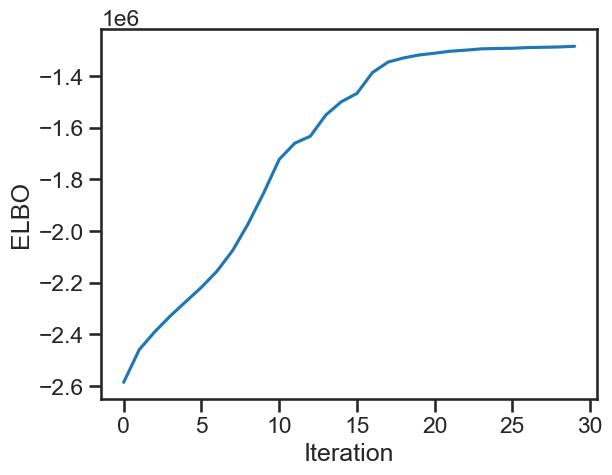

In [13]:
plt.plot(q_elbos_ar[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [69]:
z_inferred=rslds.most_likely_states(q_ar.mean_continuous_states[0],all_data)
plt.imshow(z_inferred[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1)
plt.xlim(0, 1000)
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])
plt.xlabel("time")

NameError: name 'rslds' is not defined

In [101]:
# Batch with poisson emissions
rsp_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/RSP_count_train_data.npy")
pom_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/POM_count_train_data.npy")
hpc_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/HPC_count_train_data.npy")
vpm_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/VPM_count_train_data.npy")
input_train = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/Stim_count_train_data.npy")

all_data = [rsp_train, pom_train, hpc_train, vpm_train]
N_vec = [data.shape[-1] for data in all_data]
B = all_data[0].shape[0] # Number of batches
all_data = [data.reshape(-1, data.shape[-1]) for data in all_data]
all_data = np.concatenate(all_data, axis=-1)
# separate data into list of length B
all_data = np.array_split(all_data, B, axis=0)
input_train = input_train.reshape(-1, input_train.shape[-1])
input_train = np.array_split(input_train, B, axis=0)
print(f'Number of batches: {len(all_data)}, single batch shape: {all_data[0].shape}')

K = 5
D_vec = [n // 2 for n in N_vec]
print(f'Number of neurons per population: {N_vec}')
print(f'Number of latents per population: {D_vec}')
D=np.sum(D_vec)
num_gr=len(D_vec)
D_vec_cumsum = np.concatenate(([0], np.cumsum(D_vec)))

#Get new multipopulation emissions class for the simulation

#gauss_comp_emissions=GaussianOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)
poiss_comp_emissions=PoissonOrthogonalCompoundEmissions(N=np.sum(N_vec),K=1,D=np.sum(D_vec),D_vec=D_vec,N_vec=N_vec)

#Get transitions class
sro_trans=StickyRecurrentTransitions(K=K,D=np.sum(D_vec), l2_penalty=10, l1_penalty=10) 


Number of batches: 16, single batch shape: (1900, 69)
Number of neurons per population: [6, 26, 16, 21]
Number of latents per population: [3, 13, 8, 10]


In [102]:
all_data[0].shape

(1900, 69)

In [103]:
rslds_poiss = ssm.SLDS(N=np.sum(N_vec),K=K,D=np.sum(D_vec),
             dynamics="gaussian",
             emissions=poiss_comp_emissions,
             transitions=sro_trans,
             #transition_kwargs=dict(kappa=200),
             dynamics_kwargs=dict(l2_penalty_A=100)) #Regularization on the dynamics matrix

q_elbos_ar_poiss, q_ar_poiss = rslds_poiss.fit(all_data, method="laplace_em",
                             variational_posterior="structured_meanfield", 
                             continuous_optimizer='newton',
                             initialize=True, 
                             num_init_restarts=10,
                             num_iters=30, 
                             alpha=0.25)

ARHMM Initialization restarts:   0%|          | 0/10 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  10%|█         | 1/10 [01:21<12:12, 81.40s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  20%|██        | 2/10 [02:51<11:33, 86.69s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  30%|███       | 3/10 [04:16<10:00, 85.79s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  40%|████      | 4/10 [05:44<08:40, 86.83s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  50%|█████     | 5/10 [07:04<07:00, 84.06s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  60%|██████    | 6/10 [08:31<05:40, 85.17s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  70%|███████   | 7/10 [10:00<04:19, 86.40s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  80%|████████  | 8/10 [11:20<02:48, 84.38s/it]

Initializing with an ARHMM using 25 steps of EM.


ARHMM Initialization restarts:  90%|█████████ | 9/10 [12:44<01:24, 84.26s/it]

Initializing with an ARHMM using 25 steps of EM.


ELBO: -1084104.3: 100%|██████████| 30/30 [35:31<00:00, 71.05s/it]  


Text(0, 0.5, 'ELBO')

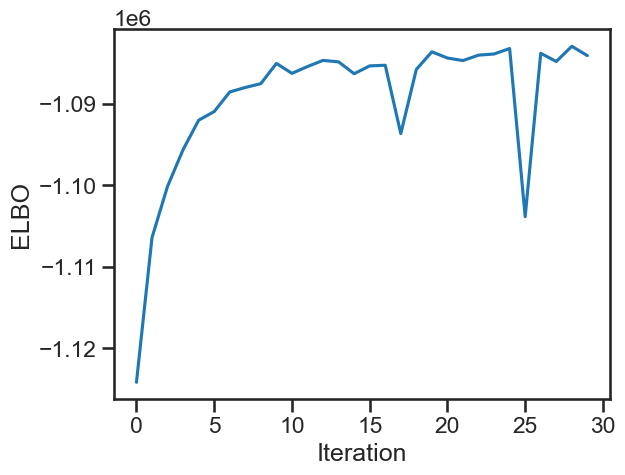

In [104]:
plt.plot(q_elbos_ar_poiss[1:])
plt.xlabel("Iteration")
plt.ylabel("ELBO")

In [105]:
len(q_ar_poiss.mean_discrete_states[0])

1900

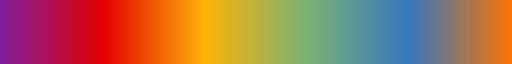

In [205]:
cmap

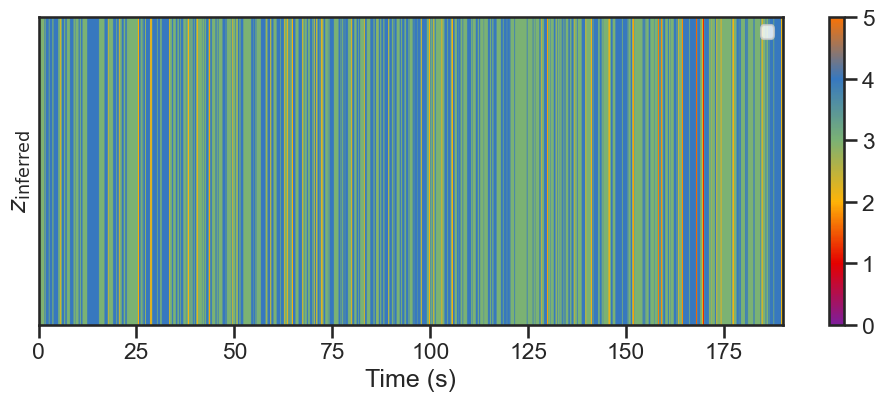

In [206]:
z_inferred = rslds_poiss.most_likely_states(q_ar_poiss.mean_continuous_states[2], all_data[2])

# Create time array in seconds
time_in_seconds = np.arange(len(z_inferred)) * 0.1

plt.figure(figsize=(12, 4))
plt.imshow(z_inferred[None,:], aspect="auto", cmap=cmap, vmin=0, vmax=len(colors)-1,
           extent=[0, len(z_inferred)*0.1, -0.5, 0.5])  # Set extent to scale x-axis
# show color legend
plt.colorbar()
plt.xlabel("Time (s)")
plt.ylabel("$z_{\\mathrm{inferred}}$")
plt.yticks([])

# color-state legend
plt.legend(labels=regions, loc='upper right', fontsize=12)

In [141]:
np.unique(z_inferred)

array([0, 1, 3, 4])

In [96]:
q_ar_poiss.mean_continuous_states[0]

array([[-0.36226965, -0.19530386, -0.4260887 , ...,  1.51812608,
         0.00403304, -0.01966006],
       [-0.52170114, -0.19846866, -0.10142878, ...,  0.81533115,
         0.16602827,  0.83432177],
       [-0.52659029, -0.71810959,  0.50830848, ...,  0.70368717,
         0.37232501,  1.61872504],
       ...,
       [-1.0457798 ,  0.08314933,  0.5476914 , ...,  1.14183929,
         0.46822817, -2.13076448],
       [-1.51811407,  0.50880291,  0.93104471, ...,  0.83680707,
        -0.0652222 , -1.34888301],
       [-1.45455493,  0.89238141,  1.20695987, ...,  1.14057054,
        -0.05978325, -1.27617646]])

In [97]:
all_data[3].shape

(1900, 69)

Text(0.5, 0, 'Time (s)')

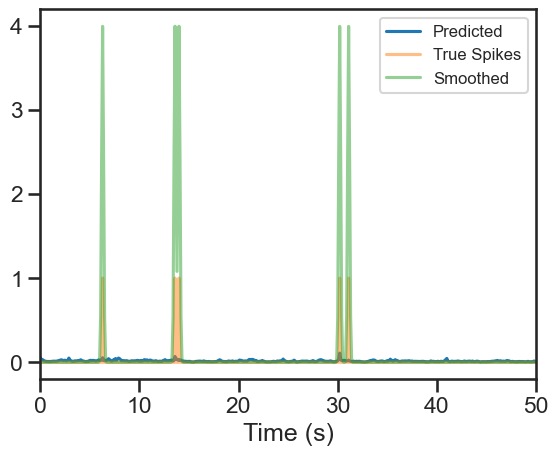

In [217]:
idx = 5
preds = rslds_poiss.smooth(q_ar_poiss.mean_continuous_states[idx], all_data[idx]) * 10
z_inferred=rslds_poiss.most_likely_states(q_ar_poiss.mean_continuous_states[idx],all_data[idx])
# From true spiking data, calculate smoothed firing rates
import scipy
smoothed_data = scipy.ndimage.gaussian_filter1d(all_data[idx].astype(float), sigma=1, axis=0) * 10
z_inferred=rslds_poiss.most_likely_states(q_ar_poiss.mean_continuous_states[idx],all_data[idx])

plt_x = np.arange(len(all_data[idx]))
nrn_idx = 6
plt.plot(plt_x / 10, preds[:, nrn_idx])
plt.plot(plt_x / 10, all_data[idx][:, nrn_idx], alpha=0.5)
plt.plot(plt_x / 10, smoothed_data[:, nrn_idx], alpha=0.5)
plt.xlim(0, 50)
# Create colored background based on z_inferred states
unique_states = np.unique(z_inferred)
ylim = plt.ylim()  # Get current y-axis limits
# for state in unique_states:
#     mask = z_inferred == state
#     plt.fill_between(np.arange(len(z_inferred)), ylim[0], ylim[1], 
#                      where=mask, color=colors[state], alpha=0.2)
plt.legend(['Predicted', 'True Spikes', 'Smoothed'], loc='upper right', fontsize=12)
# dual y-labels
#plt.ylabel("Firing Rate (Hz) / Number of Spikes")
plt.xlabel("Time (s)")


Text(0, 0.5, 'Cross-correlation: predicted vs smoothed firing rate')

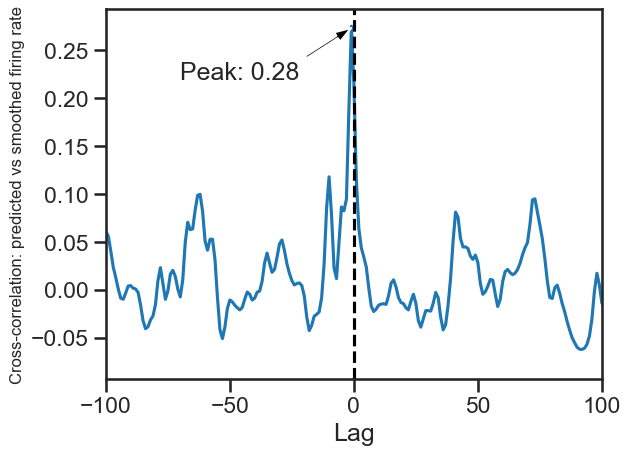

In [218]:
# Normalized cross correlation between predicted firing rate and smoothed firing rate
from scipy.signal import correlate, detrend

# Detrend both signals
preds_detrended = detrend(preds[:, nrn_idx])
smoothed_detrended = detrend(smoothed_data[:, nrn_idx])

# Compute normalized cross correlation
corr = correlate(preds_detrended, smoothed_detrended)
corr = corr / np.sqrt(np.sum(preds_detrended**2) * np.sum(smoothed_detrended**2))

x_axis = np.arange(-len(corr)//2, len(corr)//2)
plt.plot(x_axis, corr)
plt.xlabel("Lag")
plt.xlim(-100, 100)
plt.axvline(-0, color='k', linestyle='--')
plt.annotate(f'Peak: {corr.max():.2f}', xy=(0, corr.max()), xytext=(-70, corr.max()*0.8),
             arrowprops=dict(facecolor='black', shrink=0.05, width=2, headwidth=8))
plt.ylabel("Cross-correlation: predicted vs smoothed firing rate", fontsize=12)



In [112]:
# get each state usage(percentage in the time series)

states = np.unique(z_inferred)
for state in states:
    print(f'State {state}: {np.count_nonzero(z_inferred == state) / len(z_inferred)}')


State 0: 0.009473684210526316
State 1: 0.027894736842105264
State 2: 0.0015789473684210526
State 3: 0.4663157894736842
State 4: 0.49473684210526314


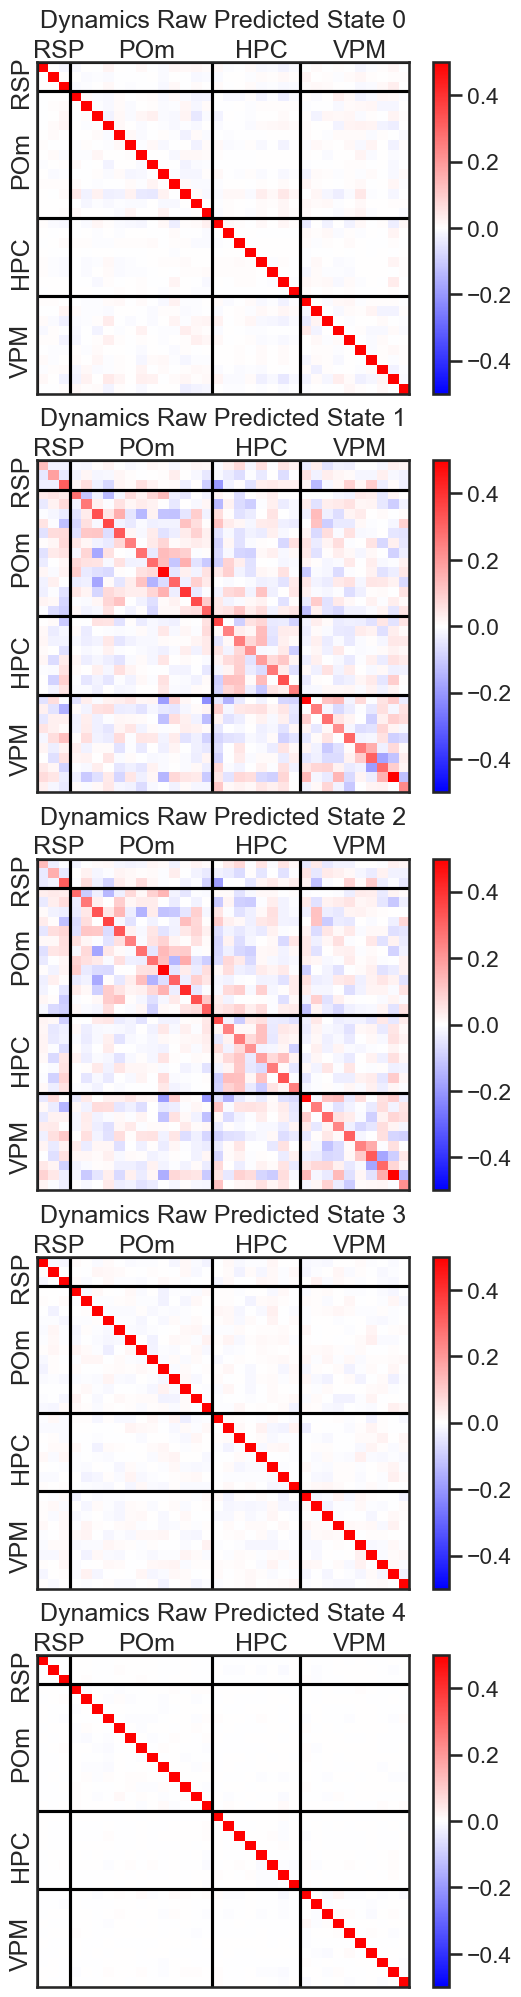

In [211]:
plt.figure(figsize=(6, 25))
regions = ['RSP', 'POm', 'HPC', 'VPM']
q=1

for k in range(K):
    
    plt.subplot(K, 1,q)
    plt.imshow(rslds_poiss.dynamics.As[k], aspect='auto', interpolation="none", vmin=-.5, vmax=.5, cmap='bwr')

    offset=-.5
    for nf in D_vec:        
        plt.plot([-0.5, D-0.5], [offset, offset], '-k')
        plt.plot([offset, offset], [-0.5, D-0.5], '-k')
        offset += nf
    # Add region labels on left and top
    offset = 0
    for i, nf in enumerate(D_vec):
        # Left side labels
        plt.text(-3, offset + nf/2, regions[i], rotation=90, verticalalignment='center')
        # Top labels 
        plt.text(offset + nf/2, -1, regions[i], horizontalalignment='center')
        offset += nf
    plt.xticks([])
    plt.yticks([])
    plt.title('Dynamics Raw Predicted State '+str(k), pad=25)
    plt.colorbar()

#     plt.savefig(folder+'dyn_est'+str(k)+'.pdf')
    
    q=q+1

# show horizontal color bar
    

        


([], [])

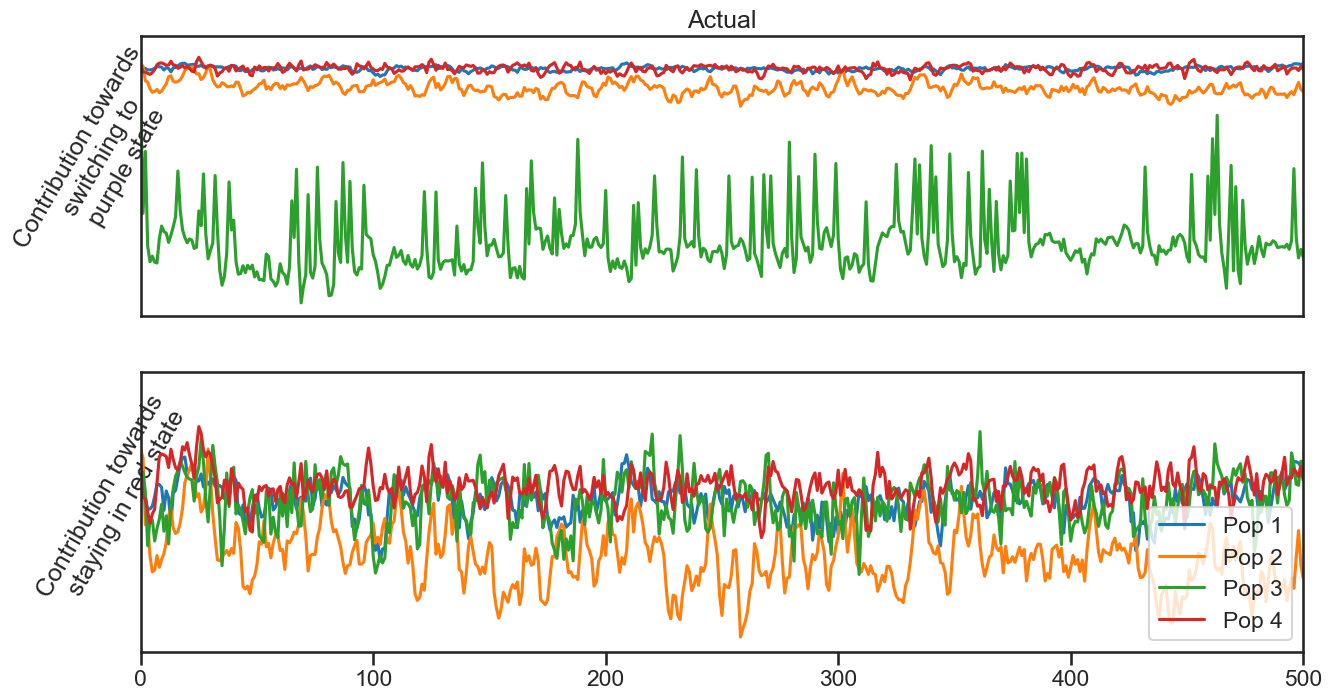

In [151]:
plt.figure(figsize=(15, 8))


### Actual

j=0

plt.subplot(211)
for g in range(K-1):
    plt.plot(np.dot(q_ar_poiss.mean_continuous_states[idx][:,D_vec_cumsum[g]:D_vec_cumsum[g+1]],rslds_poiss.transitions.Rs[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, 500)
plt.ylabel('Contribution towards \n switching to \n purple state',rotation=60)
plt.xticks([])
plt.yticks([])
plt.title('Actual')

j=1
plt.subplot(212)
for g in range(K-1):
    plt.plot(np.dot(q_ar_poiss.mean_continuous_states[idx][:,D_vec_cumsum[g]:D_vec_cumsum[g+1]],rslds_poiss.transitions.Ss[j,D_vec_cumsum[g]:D_vec_cumsum[g+1]].T))
plt.xlim(0, 500)
plt.ylabel('Contribution towards \n staying in red state',rotation=60)
plt.legend(['Pop 1','Pop 2','Pop 3', 'Pop 4'])
plt.yticks([])

In [119]:
# load test data
rsp_test = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/RSP_count_test_data.npy")
pom_test = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/POM_count_test_data.npy")
hpc_test = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/HPC_count_test_data.npy")
vpm_test = np.load("/home/xiaoliang/multi_region/data/sessions/1W_2023-05-09_01/VPM_count_test_data.npy")
all_test = [rsp_test, pom_test, hpc_test, vpm_test]
B_test = all_test[0].shape[0]
all_test = [data.reshape(-1, data.shape[-1]) for data in all_test]
all_test = np.concatenate(all_test, axis=-1)
# separate data into list of length B
all_test = np.array_split(all_test, B_test, axis=0)
print(f'Number of batches: {len(all_test)}, single batch shape: {all_test[0].shape}')




Number of batches: 4, single batch shape: (1900, 69)


In [120]:
all_test[0].shape

(1900, 69)

In [122]:
q_elbos_ar_poiss_test, q_ar_poiss_test = rslds_poiss.approximate_posterior(all_test, method="laplace_em",
                             variational_posterior="structured_meanfield", 
                             continuous_optimizer='newton',
                             num_iters=30, 
                             )


ELBO: -271312.4: 100%|██████████| 30/30 [06:17<00:00, 12.57s/it]


In [123]:
preds.shape

(1900, 69)

/tmp/ipykernel_4144267/695933462.py:10: RuntimeWarning: invalid value encountered in divide
  corr = corr / np.sqrt(np.sum(test_preds_detrended[:, nrn_idx]**2) * np.sum(test_smoothed_detrended[:, nrn_idx]**2))


276 276


Text(0, 0.5, 'Max Cross-correlation')

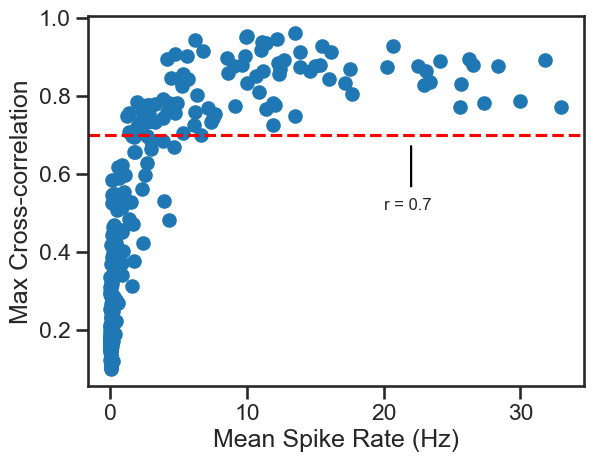

In [193]:
test_corrs = []
test_spike_counts = []
for i in range(len(all_test)):
    test_preds = rslds_poiss.smooth(q_ar_poiss_test.mean_continuous_states[i], all_test[i]) * 10
    test_smoothed = scipy.ndimage.gaussian_filter1d(all_test[i].astype(float), sigma=1, axis=0) * 10
    test_preds_detrended = detrend(test_preds, axis=0)
    test_smoothed_detrended = detrend(test_smoothed, axis=0)
    for nrn_idx in range(all_test[i].shape[-1]):
        corr = correlate(test_preds_detrended[:, nrn_idx], test_smoothed_detrended[:, nrn_idx])
        corr = corr / np.sqrt(np.sum(test_preds_detrended[:, nrn_idx]**2) * np.sum(test_smoothed_detrended[:, nrn_idx]**2))
        test_corrs.append(corr.max())
        test_spike_counts.append(np.sum(all_test[i][:, nrn_idx]))
print(len(test_corrs), len(test_spike_counts))
# plot the correlation vs spike count
test_spike_rates = np.array(test_spike_counts).astype(float) / (all_test[0].shape[0] / 10)
plt.scatter(test_spike_rates, test_corrs)
plt.xlabel("Mean Spike Rate (Hz)")
# horizontal dashed line at 0.7, with text and arrow
plt.axhline(0.7, color='r', linestyle='--')
plt.text(20, 0.5, 'r = 0.7', fontsize=12, verticalalignment='bottom')
plt.arrow(22, 0.67, 0, -0.1,  fc='k', ec='k')
#plt.axvline(1, color='r', linestyle='--')
plt.ylabel("Max Cross-correlation")


